# Homework 4: PixelCNN

In this homework you will implement a simplified version of the [PixelCNN](https://arxiv.org/pdf/1601.06759.pdf) network and train it on zero digits from the MNIST dataset.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

Here we load the MNIST dataset, select only zero digits, and "binarize" them so that the pixels are strictly ones and zeros.

In [2]:
from tensorflow.keras.datasets import mnist

# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# select only zero digits
x_train = x_train[y_train==0]
x_test = x_test[y_test==0]

# binarize the data
def binarize(x):
  return x > 0.5

x_train = binarize(x_train)
x_test = binarize(x_test)

# add a fourth dimension for use in Keras
x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)

binarized mnist images:


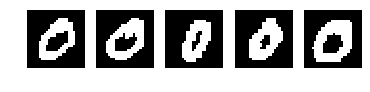

In [3]:
def show_as_image(x):
  """ Convenience function to properly show an image. """
  plt.imshow(np.squeeze(x),cmap='gray')
  plt.axis('off')

def show_grid_of_images(x):
  """ Convenience function to show five images in a row. """
  for i in range(5):
    plt.subplot(1,5,i+1)
    show_as_image(x[i])
  plt.show()
  
print('binarized mnist images:')
show_grid_of_images(x_train[:5])

### PixelCNN implementation

Here is where you will implement the [PixelCNN](https://arxiv.org/pdf/1601.06759.pdf) model.

The concept of the PixelCNN is to create a convolutoinal neural network that outputs a probability distribution **at each pixel** conditioned on all the pixels that precede it.  We consider the pixels in the image to be in row-major order (left-to-right, top-to-bottom).

So, the network outputs

$$p(x_i|x_1,\ldots,x_{i-1})$$

for each pixel $x_i$.  The predictions are done in parallel; the network takes as input the entire image $x_1,\ldots,x_n$ and outputs $p(x_i|x_1,\ldots,x_{i-1})$ at each location $i$.

If we used a traditional CNN with convolutional filter kernels, the network output at location $i$ would be able to see pixels "in the future," that is, pixels $x_i,\ldots,x_n$.  To prevent this, we need to **mask** the filter kernels so that they cannot see pixels $x_i,\ldots,x_n$.

The PixelCNN replaces the typical 2D convolution with a **masked** convolution that is not allowed to look at pixels **after** the center pixel under the filter window.  The very first convolution in the network should not look at the center pixel; later convolutions are allowed to look at the center pixel.

The masked convolution is implemented by multiplying the filter kernel with a mask of ones and zeros.  For a $5\times5$ filter kernel, the mask for the first convolution would be:

1 1 1 1 1

1 1 1 1 1

1 1 0 0 0

0 0 0 0 0

0 0 0 0 0

and the mask for the remaining convolutions would be:

1 1 1 1 1

1 1 1 1 1

1 1 1 0 0

0 0 0 0 0

0 0 0 0 0

The architecture should have the following pattern:

* Masked Conv2D with center pixel masking, 7x7 filter, K outputs + ReLU activation
* Repeat N times:
Masked Conv2D without center pixel masking, 5x5 filter, K outputs + ReLU activation
* Conv2D, 1x1 filter, 1 output + sigmoid activation

Use 'same' padding for all convolutions.  The image size (28x28) should not change throughout the network.

Note that the final 1x1 convolution does not need to be masked, since it only looks at the center pixel.

I used N=12, K=32 but you are welcome to experiment with other settings.  The training took ~5 minutes per epoch for me.

I provided a partial implementation of the MaskedConv2D layer definition; you need to fill in the part that creates the mask.





In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Cropping2D, Concatenate, Add, Activation, Lambda
import tensorflow.keras.backend as K

class MaskedConv2D(Conv2D):
  """ Masked 2D Convolution layer based on Conv2D from Keras """
  
  def __init__(self, mask_center_pixel, **kwargs):
    """ If mask_center_pixel is True, center pixel will be masked out
        so that the filter cannot see it.
    """
    super(MaskedConv2D, self).__init__(**kwargs)
    self.mask_center_pixel = mask_center_pixel

  def call(self, inputs):
    # create a mask which will be multiplied with the filter kernel below
    #
    # the kernel has size (kernel_height,kernel_width,channels_in,channels_out)
    #
    # we will make a mask with size (kernel_height,kernel_width,1,1)
    # so that when we multiply
    #
    # masked_kernel = self.kernel * mask
    #
    # the mask will be applied across all input and output channels
    #
    # note that self.kernel_size = (kernel_height,kernel_width)
    
    mask = np.ones(self.kernel_size + (1,1))
    width = self.kernel_size[0]
    height = self.kernel_size[1]
    c_x = width // 2
    c_y = height // 2
    
    # Zero out center pixel if masked is True
    if self.mask_center_pixel:
        mask[c_x,c_y] = 0
    
    # Zero out the remaining pixels in the middle row
    for y in range(c_y + 1, width):
        mask[c_x,y] = 0
    
    # Zero out remaining rows
    for x in range(c_y + 1, width):
        for y in range(height):
            mask[x,y] = 0
        

    # apply the mask to the kernel
    masked_kernel = self.kernel * mask
    
    # run the convolution operation
    outputs = K.conv2d(
      inputs,
      masked_kernel,
      strides=self.strides,
      padding='same',
      data_format=self.data_format,
      dilation_rate=self.dilation_rate)

    # add bias
    if self.use_bias:
      outputs = K.bias_add(
        outputs,
        self.bias,
        data_format=self.data_format)

    # apply activation
    if self.activation is not None:
      return self.activation(outputs)
    
    # return result
    return outputs

# create the model here
# you can create a masked conv 2D layer with x = MaskedConv2D(...)(x)
# just like the normal Keras layers
# filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
inputs = Input((28,28,1))
x = MaskedConv2D(True, filters=32, kernel_size=(7,7), activation='relu', padding='same')(inputs)
x = MaskedConv2D(False, filters=32, kernel_size=(5,5), activation='relu', padding='same')(x)
outputs = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', padding='same')(x)
model = Model(inputs=inputs,outputs=outputs)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
masked_conv2d_34 (MaskedConv (None, 28, 28, 32)        1600      
_________________________________________________________________
masked_conv2d_35 (MaskedConv (None, 28, 28, 32)        25632     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 1)         33        
Total params: 27,265
Trainable params: 27,265
Non-trainable params: 0
_________________________________________________________________
None


### Sampling from the PixelCNN model

To sample from the PixelCNN, we need to sample each pixel sequentially in row-major order, starting from the top-left and working towards the bottom-right.

So, we will sample the pixels like this:

$$x_1 \sim p(x_1)$$
$$x_2 \sim p(x_2|x_1)$$
$$x_3 \sim p(x_3|x_1,x_2)$$
$$\vdots$$
$$x_n \sim p(x_n|x_1,\ldots,x_{n-1})$$

Remember that the network outputs all of the conditional probabilities at once, but we only need one of the output values at each step.

At each step, you will call model.predict(image) to get the predicted probability of each pixel being equal to one.  Then you can select the probability value for the pixel that you need, sample it using the provided sample_bernoulli() function, and write the result into the image.

To sample an image from scratch, you will create a matrix of 28x28 zeros as your starting point.

To sample the bottom half of a test image, you will use the test image as the starting point and then sample the 14-th row down to the bottom.



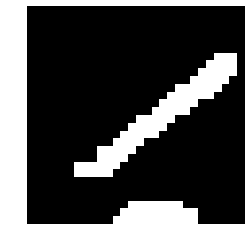

In [80]:
from tensorflow.keras.callbacks import LambdaCallback

def sample_bernoulli(p):
    """ Sample a matrix of binary values given a matrix of probability values """
    return np.random.uniform(size=p.shape) < p

def sample_image_from_scratch(return_image=False):
    """ Samples an image using the model, starting from all zeros """
    # Blank image to start
    input_image = np.zeros((1,28,28,1))
    # Loop through every pixel
    for i in range(28):
        for j in range(28):
            # Compute probabilities from all pixels given the current image
            probabilities = model.predict(input_image)
            samples = sample_bernoulli(probabilities)
            # Obtain the next pixel value and edit the input_image
            p_value = samples[0,i,j,0]
            input_image[0,i,j,0] = p_value
    if return_image:
        return input_image
    show_as_image(input_image)
    plt.show()

# sample an image from scratch and show it
sample_image_from_scratch()

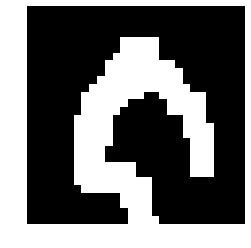

In [81]:
def complete_bottom_half(index, return_image=False):
    """ Starting with the top half of the i-th test image, samples the bottom half"""
    input_image = np.expand_dims(x_test[index],axis=0)
    # To sample the bottom half of the image, loop through each row,col starting at row 14
    for i in range(14, 28):
        for j in range(28):
            # Compute probabilities from all pixels given the current image
            probabilities = model.predict(input_image)
            samples = sample_bernoulli(probabilities)
            # Obtain the next pixel value and edit the input_image
            p_value = samples[0,i,j,0]
            input_image[0,i,j,0] = p_value
    if return_image:
        return input_image
    show_as_image(input_image)
    plt.show()

    
""" WHAT DO I DO HERE? """
def on_epoch_end(epoch, _):
    print()

    
    
# complete the bottom half of the first test image and show it
complete_bottom_half(0)

# this callback will test sampling after every epoch
image_callback = LambdaCallback(on_epoch_end=on_epoch_end)

### Training the PixelCNN model

The PixelCNN is designed to make max-likelihood training simple.  The model's pdf is easy to compute because of the autoregressive nature of the model:

$$p(x_1,\ldots,x_n) = p(x_1)p(x_2|x_1)\ldots,p(x_n|x_1,\ldots,x_{n-1})$$

$$\log p(x_1,\ldots,x_n) = \sum_i \log p(x_i|x_1,\ldots,x_{i-1})$$

To compute the negative log likelihood of a training example, we simply run the model with the training example as input and sum up the per-pixel cross entropy loss.

Since we have binary data, we will use the binary cross-entropy loss function.

There is nothing for you to implement here -- I am just explaining to you what it is doing internally :)

In [50]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [51]:
model.fit(x_train, x_train,
          batch_size=16,
          epochs=10,
          callbacks=[image_callback])

Epoch 1/10
5923/5923 [==============================] - 2s 261us/step - loss: 2.6963
Epoch 2/10
5923/5923 [==============================] - 1s 209us/step - loss: 1.6823
Epoch 3/10
5923/5923 [==============================] - 1s 209us/step - loss: 1.6352
Epoch 4/10
5923/5923 [==============================] - 1s 209us/step - loss: 1.6107
Epoch 5/10
5923/5923 [==============================] - 1s 214us/step - loss: 1.5944
Epoch 6/10
5923/5923 [==============================] - 1s 201us/step - loss: 1.5779
Epoch 7/10
5923/5923 [==============================] - 1s 200us/step - loss: 1.5674
Epoch 8/10
5923/5923 [==============================] - 1s 201us/step - loss: 1.5591
Epoch 9/10
5923/5923 [==============================] - 1s 200us/step - loss: 1.5498
Epoch 10/10
5923/5923 [==============================] - 1s 201us/step - loss: 1.5444


### Exercises

* Complete the implementation of the masked convolution layer (above)
* Implement the PixelCNN model (above)
* Implement the sampling functions (above)
* Once the model has finished training, sample a large number of images and try to determine whether the network exhibits mode collapse, like GANs sometimes do.  
* Critical thinking questions (no code required): Can the PixelCNN auto-complete the **top half** of an image? If not, how would you modify the network to do that?  How could you make it auto-complete the left or right halves?

In [88]:
def show_25_images(x):
    counter = 0
    for i in range(5):
        for j in range(5):
            plt.subplot(5,5,counter+1)
            show_as_image(x[counter])
            counter += 1
    plt.show()

### Sample Images from Scratch

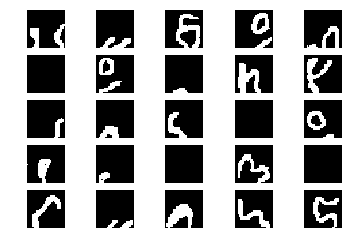

In [90]:
samples = []
for i in range(25):
    samples.append(sample_image_from_scratch(return_image=True))
show_25_images(samples)

### Completed Bottom Halves of Testing Images

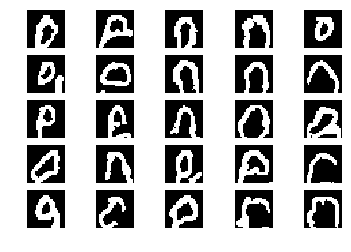

In [91]:
samples = []
for i in range(25):
    samples.append(complete_bottom_half(i, return_image=True))
show_25_images(samples)

#### Is there moad collapse? (Doesn't look like it).

#### Can the PixelCNN auto-complete the top half/left/right parts of an image?
